The notebook is clear and organized and easy to follow. I would recommend using a heatmap which can show the correlation to BeatsPerMinutes to help see the strongest predictors for your final model. Possibly add more headings and descriptions.

In [14]:
# Imports
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [15]:
# Load dataset
df = pd.read_csv("/kaggle/input/test-and-training-data/train.csv")

In [16]:
df.head()


,id,RhythmScore,AudioLoudness,VocalContent,AcousticQuality,InstrumentalScore,LivePerformanceLikelihood,MoodScore,TrackDurationMs,Energy,BeatsPerMinute
0,0,0.603610,-7.636942,0.023500,0.000005,0.000001,0.051385,0.409866,290715.6450,0.826267,147.53020
1,1,0.639451,-16.267598,0.071520,0.444929,0.349414,0.170522,0.651010,164519.5174,0.145400,136.15963
2,2,0.514538,-15.953575,0.110715,0.173699,0.453814,0.029576,0.423865,174495.5667,0.624667,55.31989
3,3,0.734463,-1.357000,0.052965,0.001651,0.159717,0.086366,0.278745,225567.4651,0.487467,147.91212
4,4,0.532968,-13.056437,0.023500,0.068687,0.000001,0.331345,0.477769,213960.6789,0.947333,89.58511


In [17]:
# Check correlations with the target
correlations = df.corr()['BeatsPerMinute'].sort_values(ascending=False)
print(correlations)

BeatsPerMinute               1.000000
MoodScore                    0.007059
TrackDurationMs              0.006637
RhythmScore                  0.005440
VocalContent                 0.004876
LivePerformanceLikelihood    0.003471
InstrumentalScore            0.001900
id                          -0.000355
AcousticQuality             -0.000820
AudioLoudness               -0.003327
Energy                      -0.004375
Name: BeatsPerMinute, dtype: float64


In [18]:
# Features and target 
# Drop target + id columns
X_raw = df.drop(columns=['BeatsPerMinute', 'id'])
y = df['BeatsPerMinute']

print (X_raw.shape)

(524164, 9)


In [19]:
#Drop low-variance features
selector = VarianceThreshold(threshold=0.01)
X_filtered = pd.DataFrame(
    selector.fit_transform(X_raw),
    columns=X_raw.columns[selector.get_support()]
)
print (X_filtered.shape)

(524164, 8)


In [20]:
# Feature engineering: Convert TrackDurationMs from milliseconds to seconds
if 'TrackDurationMs' in X_raw.columns:
    X_raw['TrackDurationMs'] = X_raw['TrackDurationMs'] / 1000.0
    


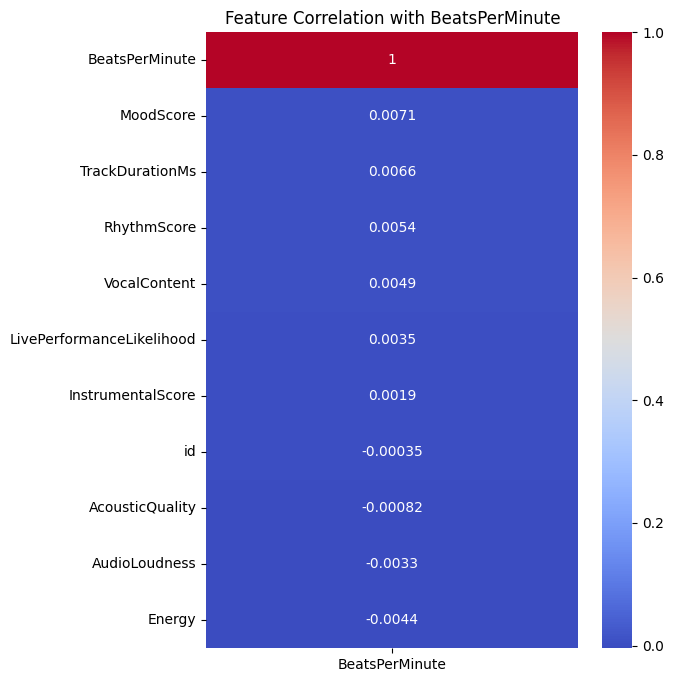

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr = df.corr()

# Plot heatmap
plt.figure(figsize=(6,8))
sns.heatmap(corr[['BeatsPerMinute']].sort_values(by='BeatsPerMinute', ascending=False),
            cmap="coolwarm", annot=True)
plt.title("Feature Correlation with BeatsPerMinute")
plt.show()



In [22]:
# Train/Test split
X_train, X_val, y_train, y_val = train_test_split(
    X_raw, y, test_size=0.2, random_state=42
)

In [23]:
# Linear Regression 
lin_reg = make_pipeline(LinearRegression())
lin_reg.fit(X_train, y_train)

y_pred_lin = lin_reg.predict(X_val)
mse_lin = mean_squared_error(y_val, y_pred_lin)
rmse_lin = np.sqrt(mse_lin)
print("Linear Regression RMSE:", rmse_lin)


Linear Regression MSE: 699.2787814313143
Linear Regression RMSE: 26.443879848299762


In [33]:
# Ridge Regression 
ridge = make_pipeline(StandardScaler(), Ridge(alpha=10))
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_val)
mse_ridge = mean_squared_error(y_val, y_pred_ridge)
rmse_ridge = np.sqrt(mse_ridge)
print("Ridge Regression RMSE:", rmse_ridge)

Ridge Regression RMSE: 26.443879823959403


In [35]:
# Random Forest 
rf = RandomForestRegressor(
    n_estimators=100, max_depth=10, max_features='sqrt',
    random_state=42, n_jobs=2
)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)
mse_rf = mean_squared_error(y_val, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
print("Random Forest RMSE:", rmse_rf)

Random Forest RMSE: 26.43883444246399


In [34]:
# Baseline (mean predictor) 
baseline_pred = np.full_like(y_val, y_train.mean())
mse_baseline = mean_squared_error(y_val, baseline_pred)
rmse_baseline = np.sqrt(mse_baseline)
print("Baseline RMSE:", rmse_baseline)

Baseline RMSE: 26.445357100903113


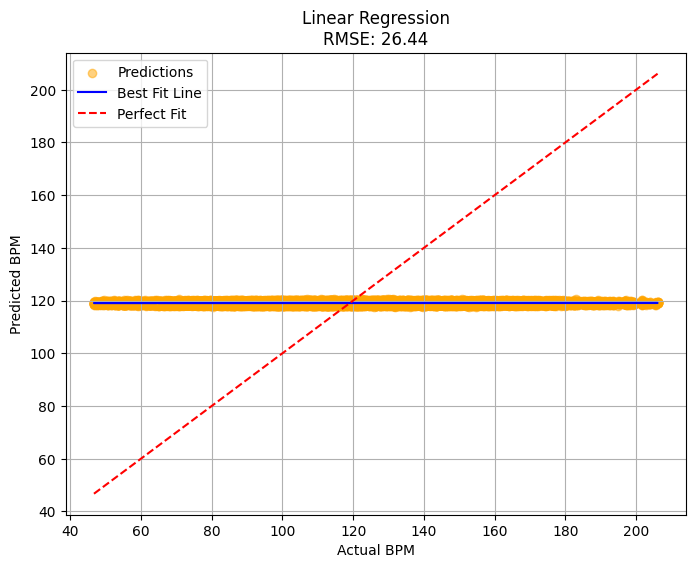

In [37]:
# Linear Regression best fit line
plt.figure(figsize=(8,6))
plt.scatter(y_val, y_pred_lin, alpha=0.5, color='orange', label="Predictions")

# Overlay best fit line from linear regression
fit_lin = LinearRegression().fit(y_val.values.reshape(-1,1), y_pred_lin)
plt.plot(y_val, fit_lin.predict(y_val.values.reshape(-1,1)), 'b-', label="Best Fit Line")

# Perfect fit line
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', label="Perfect Fit")

plt.xlabel("Actual BPM")
plt.ylabel("Predicted BPM")
plt.title(f"Linear Regression\nRMSE: {rmse_lin:.2f}")
plt.legend()
plt.grid(True)
plt.show()

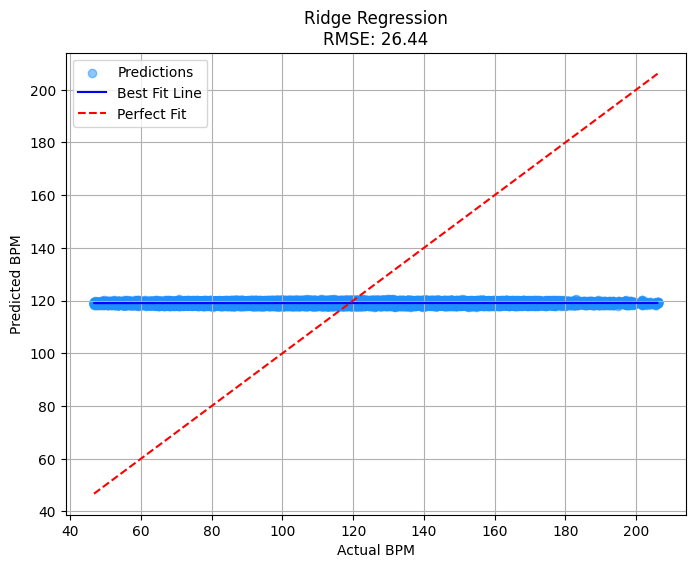

In [38]:
# Ridge Regression best fit line
plt.figure(figsize=(8,6))
plt.scatter(y_val, y_pred_ridge, alpha=0.5, color='dodgerblue', label="Predictions")

fit_ridge = LinearRegression().fit(y_val.values.reshape(-1,1), y_pred_ridge)
plt.plot(y_val, fit_ridge.predict(y_val.values.reshape(-1,1)), 'b-', label="Best Fit Line")

plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', label="Perfect Fit")

plt.xlabel("Actual BPM")
plt.ylabel("Predicted BPM")
plt.title(f"Ridge Regression\nRMSE: {rmse_ridge:.2f}")
plt.legend()
plt.grid(True)
plt.show()

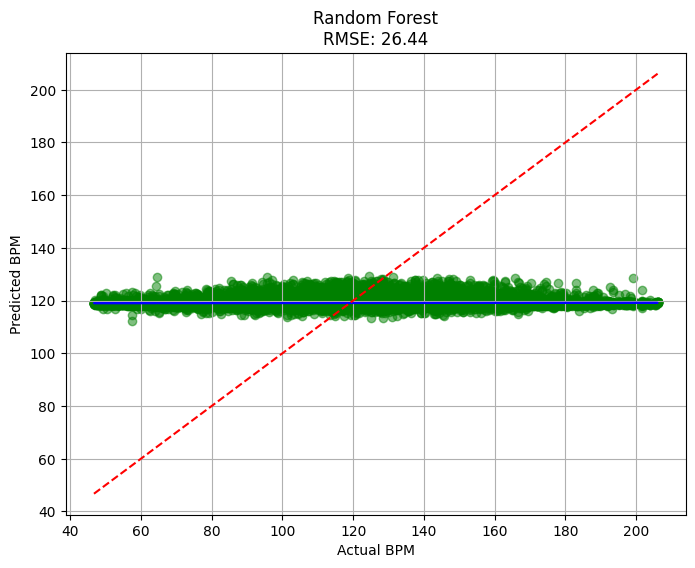

In [43]:
# Random Forest Plot
plt.figure(figsize=(8,6))
plt.scatter(y_val, y_pred_rf, alpha=0.5, color='green')
fit_rf = LinearRegression().fit(y_val.values.reshape(-1,1), y_pred_rf)
y_line = fit_rf.predict(y_val.values.reshape(-1,1))
plt.plot(y_val, y_line, 'b-', label="Best Fit Line")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("Actual BPM")
plt.ylabel("Predicted BPM")
plt.title(f"Random Forest\nRMSE: {rmse_rf:.2f}")
plt.grid(True)
plt.show()


In [41]:
# Show prefomance metrics, rmse 
# Collect metrics
metrics = {
    "Baseline": {"MSE": mse_baseline, "RMSE": rmse_baseline},
    "Linear Regression": {"MSE": mse_lin, "RMSE": rmse_lin},
    "Ridge Regression": {"MSE": mse_ridge, "RMSE": rmse_ridge},
    "Random Forest": {"MSE": mse_rf, "RMSE": rmse_rf}
}

# Convert to DataFrame for display
metrics_df = pd.DataFrame(metrics).T
print(metrics_df)


                          MSE       RMSE
Baseline           699.356912  26.445357
Linear Regression  699.278781  26.443880
Ridge Regression   699.278780  26.443880
Random Forest      699.011967  26.438834
